# Brain MRI Dataset - Data Analysis

Dataset Source Link: https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation/data

### About Dataset
#### LGG Segmentation Dataset
Dataset used in:

Mateusz Buda, AshirbaniSaha, Maciej A. Mazurowski "Association of genomic subtypes of lower-grade gliomas with shape features automatically extracted by a deep learning algorithm." Computers in Biology and Medicine, 2019.

and

Maciej A. Mazurowski, Kal Clark, Nicholas M. Czarnek, Parisa Shamsesfandabadi, Katherine B. Peters, Ashirbani Saha "Radiogenomics of lower-grade glioma: algorithmically-assessed tumor shape is associated with tumor genomic subtypes and patient outcomes in a multi-institutional study with The Cancer Genome Atlas data." Journal of Neuro-Oncology, 2017.

This dataset contains brain MR images together with manual FLAIR abnormality segmentation masks.
The images were obtained from The Cancer Imaging Archive (TCIA).
They correspond to 110 patients included in The Cancer Genome Atlas (TCGA) lower-grade glioma collection with at least fluid-attenuated inversion recovery (FLAIR) sequence and genomic cluster data available.
Tumor genomic clusters and patient data is provided in data.csv file.
For more information on genomic data, refer to the publication "Comprehensive, Integrative Genomic Analysis of Diffuse Lower-Grade Gliomas" and supplementary material available at https://www.nejm.org/doi/full/10.1056/NEJMoa1402121

In [1]:
import matplotlib.pyplot as plt

from brain_mri_dataset import BrainMRIDataset


In [2]:
dataset_path = './data/lgg-mri-segmentation/kaggle_3m'
dataset = BrainMRIDataset(root_path=dataset_path)
print(len(dataset))

3929


Training batch - Image shape: torch.Size([10, 3, 256, 256])
Training batch - Mask shape: torch.Size([10, 1, 256, 256])
Validation batch - Image shape: torch.Size([10, 3, 256, 256])
Validation batch - Mask shape: torch.Size([10, 1, 256, 256])
Visualizing training data:


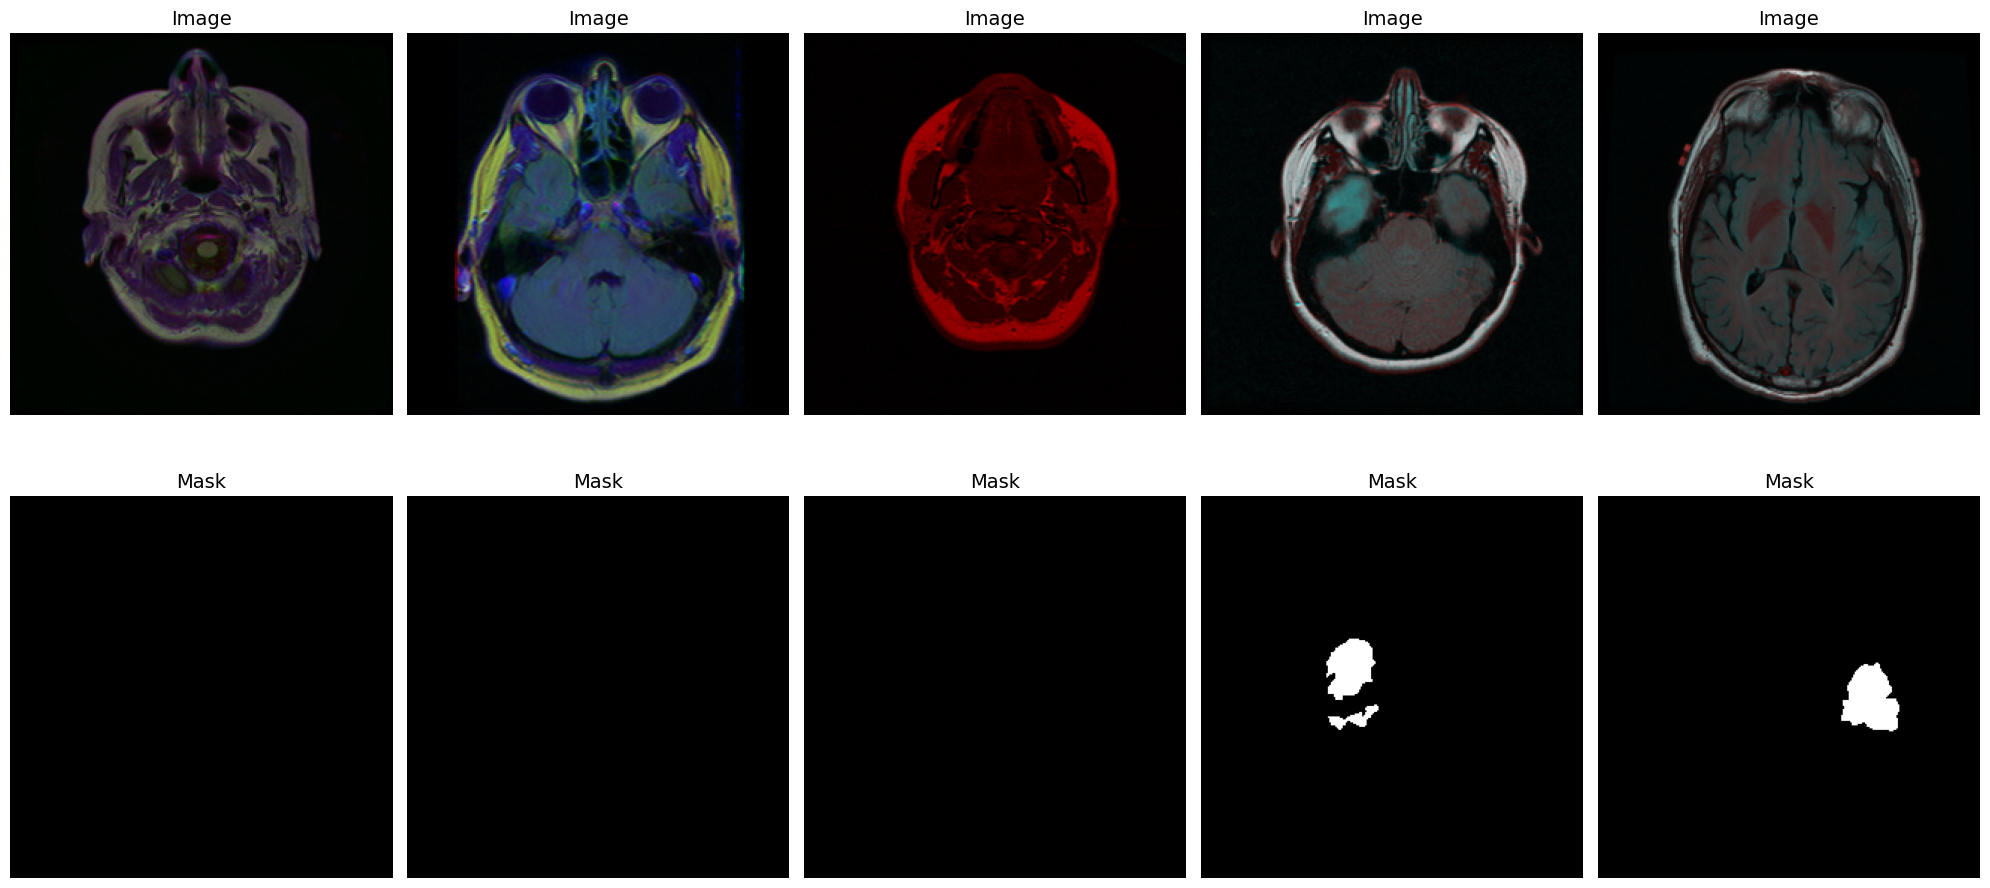

Visualizing validation data:


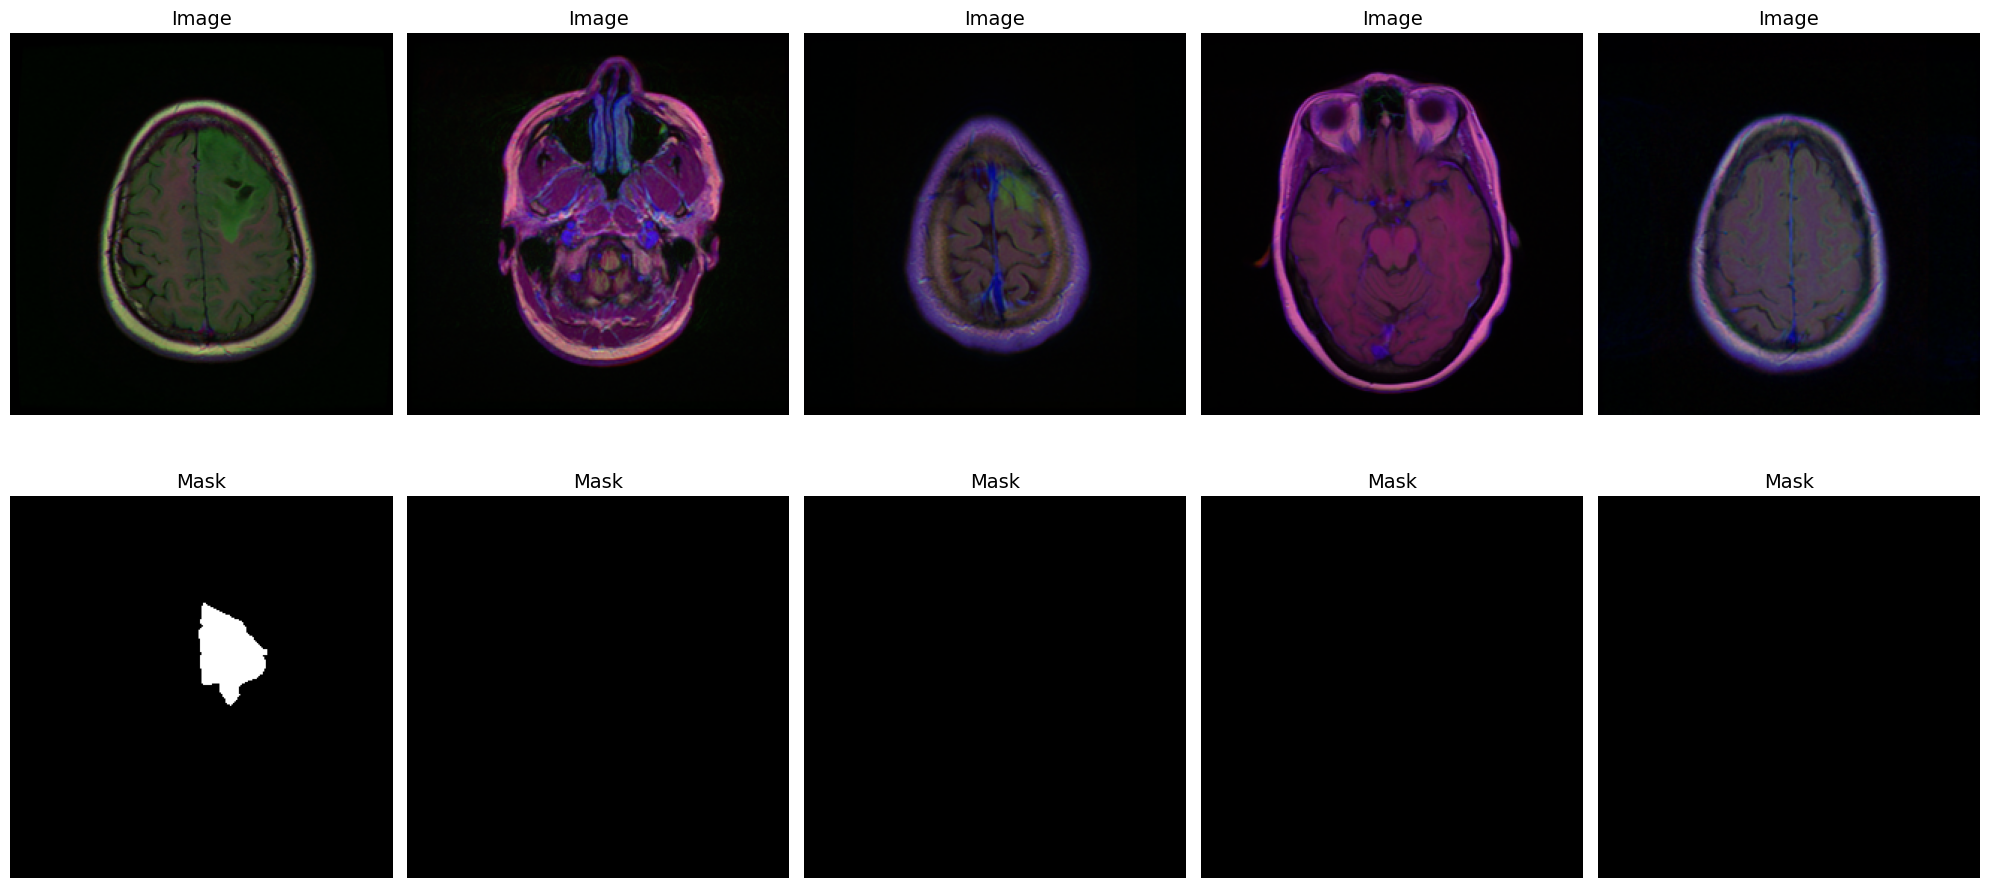

In [3]:
from data_utils import get_data_loaders
from utils import plot_img

# Create DataLoader objects
train_loader, val_loader = get_data_loaders(dataset, batch_size=10, train_size=0.9)

# Explore the training data
for images, masks in train_loader:
    print("Training batch - Image shape:", images.shape)
    print("Training batch - Mask shape:", masks.shape)
    break

# Explore the validation data
for images, masks in val_loader:
    print("Validation batch - Image shape:", images.shape)
    print("Validation batch - Mask shape:", masks.shape)
    break

# Visualize training data
print("Visualizing training data:")
plot_img(num_images=5, data_loader=train_loader)

# Visualize validation data
print("Visualizing validation data:")
plot_img(num_images=5, data_loader=val_loader)

In [4]:
for images, masks in train_loader:
    print(f"Image min: {images.min()}, max: {images.max()}")
    print(f"Mask min: {masks.min()}, max: {masks.max()}")
    print(f"Image shape: {images.shape}")
    print(f"Mask shape: {masks.shape}")
    break

Image min: 0.0, max: 0.9725490212440491
Mask min: 0.0, max: 1.0
Image shape: torch.Size([10, 3, 256, 256])
Mask shape: torch.Size([10, 1, 256, 256])


## Model Validation

In [5]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from unet import UNet  
from data_utils import get_data_loaders  

# Load DataLoader
_, val_loader = get_data_loaders(dataset, batch_size=1, train_size=0.9)

# Paths to saved checkpoints
checkpoint_paths = [
    "model_checkpoints/unet_trial1.pth",
    "model_checkpoints/unet_trial2.pth",
    "model_checkpoints/unet_trial3.pth",
    "model_checkpoints/unet_trial4.pth",
]

# Initialize the model
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"MPS available: {torch.backends.mps.is_available()}")
print(f"Using device: {device}")
model = UNet(in_channels=3, num_classes=1)  
model.to(device)

MPS available: True
Using device: mps


UNet(
  (encoder1): DownSample(
    (conv): DoubleConv(
      (conv_op): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (encoder2): DownSample(
    (conv): DoubleConv(
      (conv_op): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(128, eps=1e-

In [21]:
# Metric storage
model_accuracies = []
sample_image = None
sample_actual_mask = None
sample_predicted_masks = []

# Evaluate each model
for path in checkpoint_paths:
    print(f"Evaluating checkpoint: {path}")
    
    # Load checkpoint
    checkpoint = torch.load(path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    running_accuracy = []
    
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            preds = (outputs > 0.5).float()  # Threshold for binary mask
            
            # Calculate Dice Coefficient or Accuracy
            intersection = (preds * masks).sum((1, 2, 3))
            union = preds.sum((1, 2, 3)) + masks.sum((1, 2, 3))
            dice = (2.0 * intersection / (union + 1e-7)).mean().item()
            running_accuracy.append(dice)
            
    # Save a sample for visualization
    if sample_image is None or len(sample_predicted_masks)<len(checkpoint_paths):
        sample_image = images.cpu().squeeze(0).numpy()
        sample_actual_mask = masks.cpu().squeeze(0).numpy()
        sample_predicted_masks.append(preds.cpu().squeeze(0).numpy())
    
    # Store average accuracy for the model
    avg_accuracy = np.mean(running_accuracy)
    model_accuracies.append(avg_accuracy)

Evaluating checkpoint: model_checkpoints/unet_trial1.pth


/var/folders/6k/jr_d8wn93pxcqvlty9jjc6x00000gn/T/ipykernel_72885/2727557924.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_location=d

Evaluating checkpoint: model_checkpoints/unet_trial2.pth
Evaluating checkpoint: model_checkpoints/unet_trial3.pth
Evaluating checkpoint: model_checkpoints/unet_trial4.pth


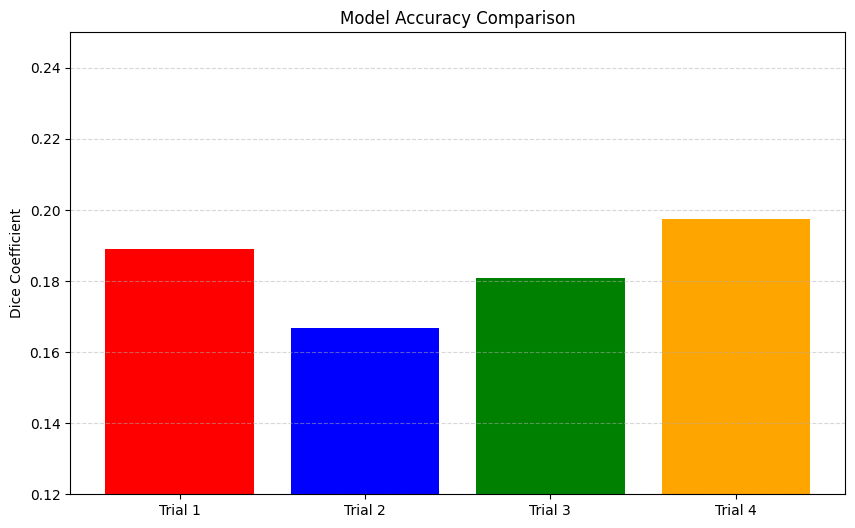

In [16]:
# Plot accuracy comparison 
plt.figure(figsize=(10, 6))
plt.bar(
    [1, 2, 3, 4], 
    model_accuracies, 
    tick_label=["Trial 1", "Trial 2", "Trial 3", "Trial 4"], 
    color=['red', 'blue', 'green', 'orange']
)

plt.title("Model Accuracy Comparison")
plt.ylabel("Dice Coefficient")
plt.ylim(0.12, 0.25) 
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

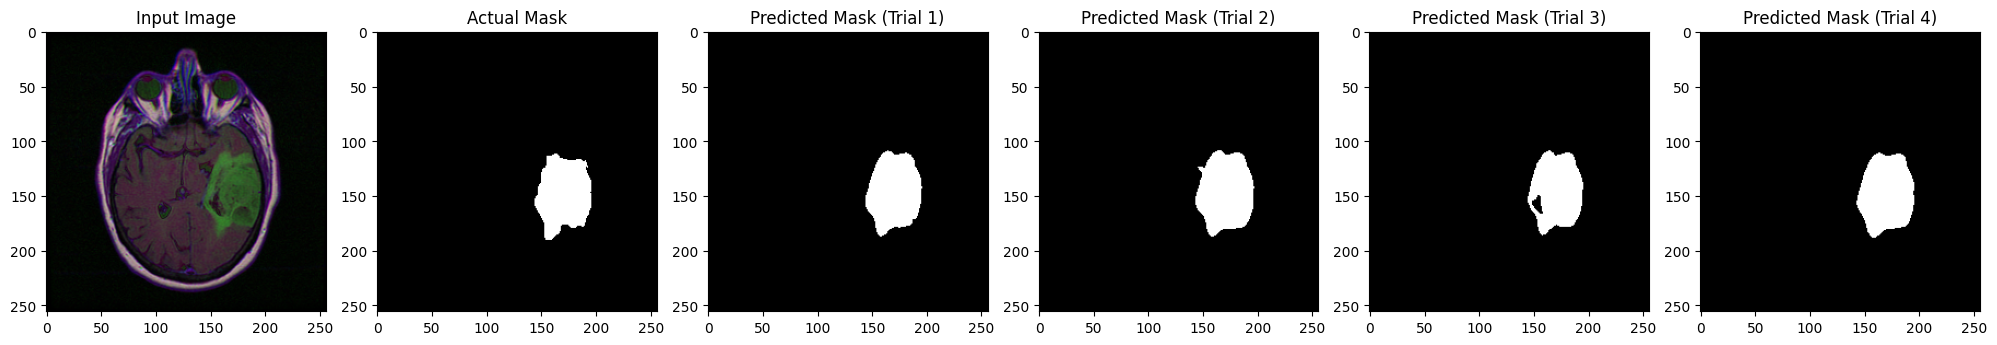

In [23]:
# Ensure the image has the correct shape for imshow
sample_image = sample_image.squeeze()  # Remove singleton dimension if shape is (1, 3, H, W)
sample_actual_mask = sample_actual_mask.squeeze()  # Remove singleton dimension if shape is (1, H, W)
sample_predicted_masks = [pred_mask.squeeze() for pred_mask in sample_predicted_masks]  # Remove singleton dimensions

# Transpose the image if it has 3 channels (e.g., (3, H, W))
if len(sample_image.shape) == 3 and sample_image.shape[0] == 3:
    sample_image = sample_image.transpose(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)

# Plot sample image with actual and predicted masks
fig, axes = plt.subplots(1, len(sample_predicted_masks) + 2, figsize=(20, 5))

# Input image
axes[0].imshow(sample_image, cmap='gray' if sample_image.ndim == 2 else None)
axes[0].set_title("Input Image")

# Actual mask
axes[1].imshow(sample_actual_mask, cmap='gray')
axes[1].set_title("Actual Mask")

# Predicted masks
for i, pred_mask in enumerate(sample_predicted_masks):
    axes[i + 2].imshow(pred_mask, cmap='gray')
    axes[i + 2].set_title(f"Predicted Mask (Trial {checkpoint_paths[i][-5:-4]})")

plt.tight_layout()
plt.show()